In [1]:
!pip install shap
!git clone https://github.com/ultralytics/yolov5

     |████████████████████████████████| 358kB 8.7MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489391 sha256=5b270bcb60dd878aaeb76f6e9401b816480a26f4590d94ab9c966d2ca5209bae
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
Cloning into 'yolov5'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4420 (delta 0), reused 1 (delta 0), pack-reused 4416
Receiving objects: 100% (4420/4420), 7.39 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (2996/2996), done.
Cloning into 'image-mask-estimatee'...
fatal: could not read Username for 'https://github.com': No such device or address


In [8]:
!git clone https://github.com/biplav-s/image-mask-estimate

Cloning into 'image-mask-estimate'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 2), reused 31 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [2]:
!sed -i "s/return F.hardswish(input, self.inplace)/return F.hardswish(input)/" /usr/local/lib/python3.6/dist-packages/torch/nn/modules/activation.py 

In [3]:
from google.colab import files
files.upload()

Saving best.pt to best.pt


In [4]:
%cd yolov5

/content/yolov5


In [15]:
import json
import random
from glob import glob
import torch
import torch.backends.cudnn as cudnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shap
import cv2
from PIL import Image
%matplotlib inline
from utils.general import non_max_suppression, box_iou
device = torch.device('cuda:0')

In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [18]:
model = torch.load("../best.pt", map_location=device)['model'].float().autoshape()
_ = model.half() # use half precision float16 values

Adding autoShape... 


In [54]:
def image_processing(path,img_size,show_image_processing=0):
  img_org = cv2.imread(path, cv2.IMREAD_COLOR)
  img_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
  old_img_size = img_org.shape[:2] # old size is in (height, width) format

  ratio = float(img_size)/max(old_img_size)
  new_size_y, new_size_x = tuple([int(x*ratio) for x in old_img_size])
  img = cv2.resize(img_org, (new_size_x, new_size_y))

  delta_w = img_size - new_size_x
  delta_h = img_size - new_size_y
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

  img = img.astype("float64")/255
  img_gray = rgb2gray(img)    
  
  if show_image_processing :
    plt.figure(figsize=(15, 15))
    plt.imshow(img_org)
    plt.show()

    fig = plt.figure(figsize=(20, 40))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    plt.show()
  return img_org,img,img_gray

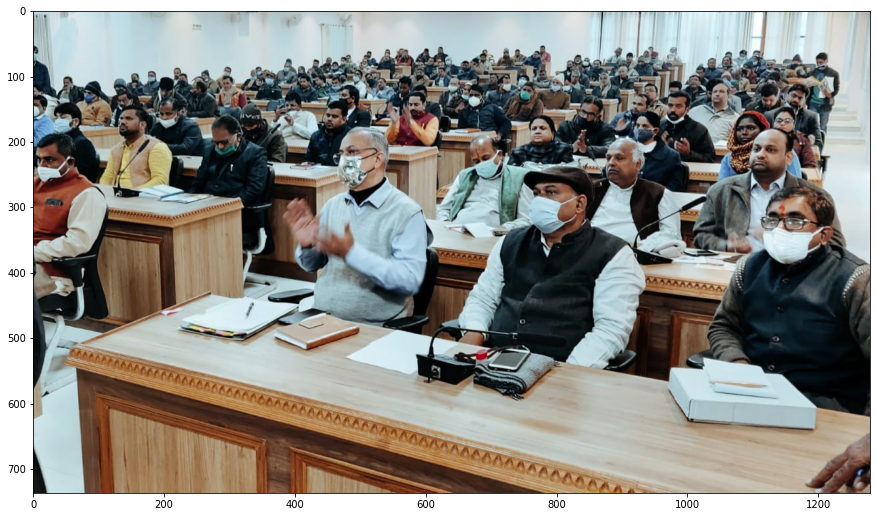

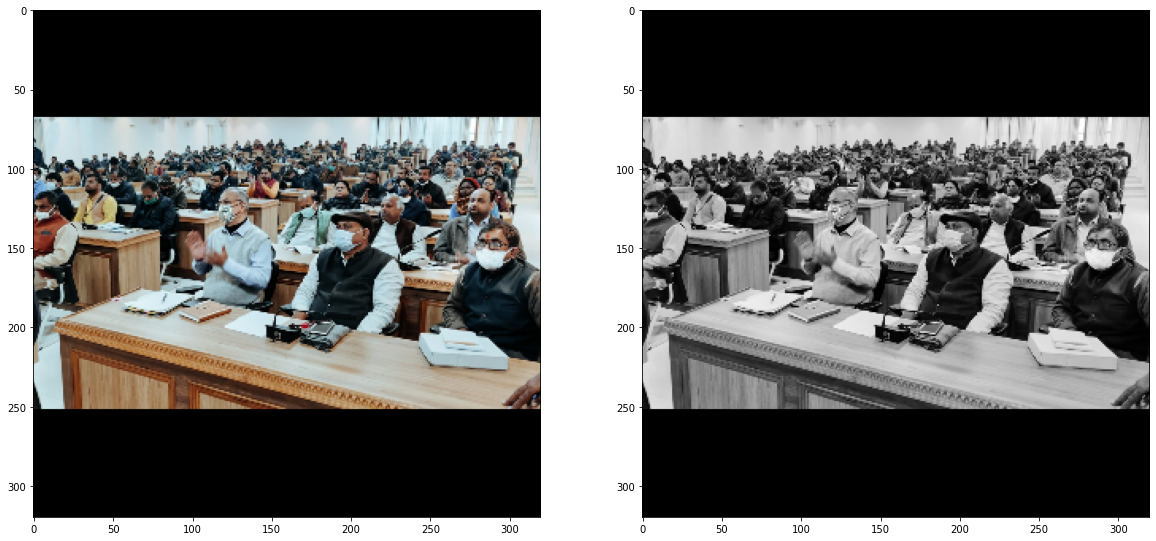

In [56]:
img_org,img_pre,img_gray=image_processing('/content/image-mask-estimate/data/sample-images-india/2.jpg',10*32,1)

In [63]:
def model_processing(img,confidence,iou,show_yolo_result=0):
  torch_image = torch.from_numpy(np.ascontiguousarray(img.transpose(2, 0, 1))).to(device).unsqueeze(0).half()
  prediction = model(torch_image)
  output = non_max_suppression(prediction[0], conf_thres=confidence, iou_thres=iou)
  if show_yolo_result :
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1)

    plt.imshow(img)
    for i, detection in enumerate(output[0].cpu().numpy()):
      label = f"{model.names[int(detection[5])]} {detection[4]:0.1%} ({i})"
      bbox = patches.Rectangle(detection[:2], detection[2]-detection[0], detection[3]-detection[1], linewidth=3, edgecolor='g', facecolor='none')
      plt.text(detection[0], detection[1], label, color="red")
      ax.add_patch(bbox)
    plt.show()
  
  return output,prediction

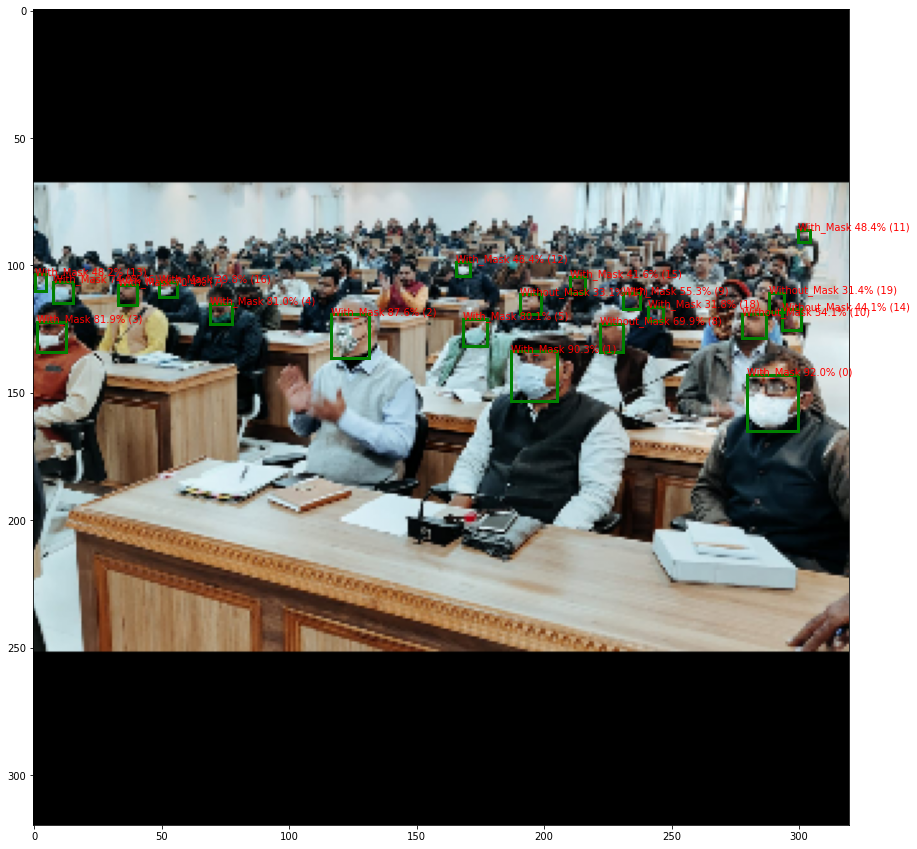

In [64]:
output,prediction=model_processing(img_pre,0.3,0.3,1)

In [65]:
class CastNumpy(torch.nn.Module):
  def __init__(self):
    super(CastNumpy, self).__init__()
  
  def forward(self, image):
    #In the forward function we accept the inputs and cast them to a pytorch tensor
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image).to(device)
    if image.ndimension() == 3:
      image = image.unsqueeze(0)
    image_half = image.half()
    
    return image_half

numpy2torch_converter = CastNumpy()

In [66]:
numpy2torch_converter.forward(img_pre.transpose(2, 0, 1))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0', dtype=torch.float16)

In [67]:
class OD2Score(torch.nn.Module):
    def __init__(self, target, conf_thresh=0.01, iou_thresh=0.5):
        super(OD2Score, self).__init__()
        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh
        self.target = torch.tensor(target, device=device)

    def forward(self, x):
        #In the forward function we accept the predictions and return the score for a selected target of the box
        score_best_box = torch.zeros([x[0].shape[0]], device=device)

        for idx, img in enumerate(x[0]):
          img = img.unsqueeze(0)
        
          output = non_max_suppression(img, conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)
          if output and output[0] is not None:
            correct_class_predictions = output[0][...,5] == self.target[5]
            correctly_labeled_boxes = output[0][correct_class_predictions]
            
            if correctly_labeled_boxes.shape[0]:
              iou_with_target, _idx = box_iou(correctly_labeled_boxes[:,:4], self.target.unsqueeze(0)[:,:4]).max(1)
              index_best_box_in_correct_class = torch.argmax(iou_with_target)
              index_best_box_in_output = torch.where(output[0][...,5] == self.target[5])[0][index_best_box_in_correct_class]

              score_best_box[idx] = output[0][index_best_box_in_output][4]*iou_with_target[index_best_box_in_correct_class]

        return score_best_box.cpu().numpy()

In [103]:
# look at the image output above and set the index of the object you want to analyze here
target_index = 8
target = output[0].cpu().numpy()[target_index,:]
scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)
print(scoring.forward(prediction), "# score for target prediction")

[    0.69922] # score for target prediction


In [104]:
class SuperPixler(torch.nn.Module):
  def __init__(self, image, super_pixel_width):
    super(SuperPixler, self).__init__()
    
    self.image = image.transpose(2, 0, 1) # model expects images in BRG, not RGB, so transpose color channels
    self.mean_color = self.image.mean()
    self.image = np.expand_dims(self.image, axis=0)
    self.image_width = image.shape[1]
    self.super_pixel_width = super_pixel_width

  
  def forward(self, x):
    #In the forward step we accept the super pixel masks and transform them to a batch of images
    pixeled_image = np.repeat(self.image.copy(), x.shape[0], axis=0)

    for i, super_pixel in enumerate(x.T):
      images_to_pixelate = [bool(p) for p in super_pixel]
      x = (i*self.super_pixel_width//self.image_width)*self.super_pixel_width
      y = i*self.super_pixel_width%self.image_width
      pixeled_image[images_to_pixelate,:,x:x+self.super_pixel_width, y:y+self.super_pixel_width] = self.mean_color
    
    return pixeled_image

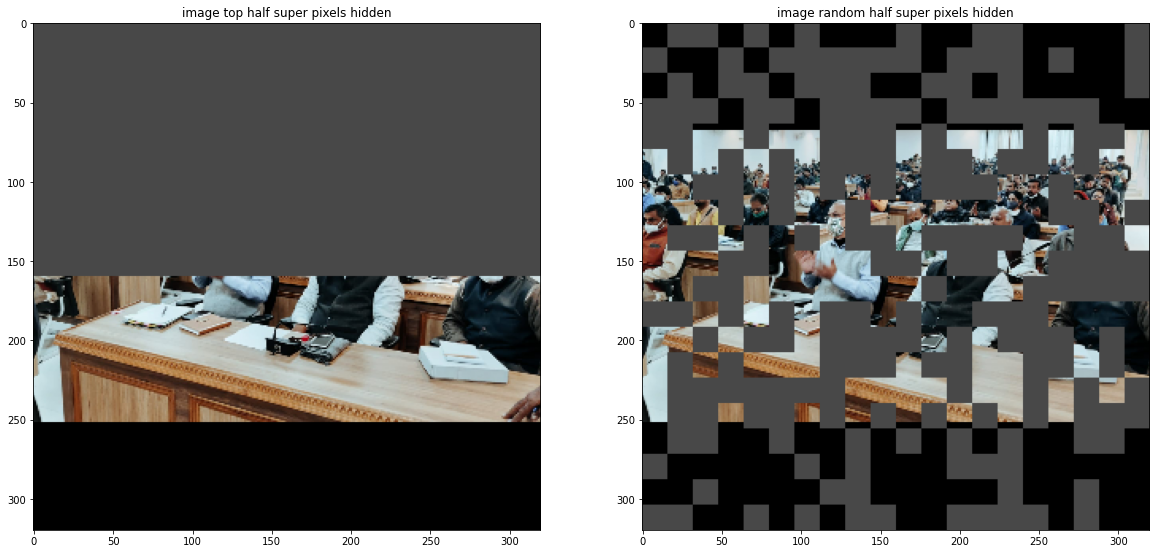

In [105]:
super_pixel_width = 16
assert (320/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width"   
n_super_pixel = int((img_pre.shape[1]/super_pixel_width)**2)

super_pixler = SuperPixler(img_pre, super_pixel_width = super_pixel_width)
img_s = super_pixler.forward(np.array([[1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], 
                                       [random.randint(0,1) for _ in range(n_super_pixel)]]))
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("image top half super pixels hidden")
ax1.imshow(img_s[0,:,:,:].transpose(1,2,0))
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("image random half super pixels hidden")
ax2.imshow(img_s[1,:,:,:].transpose(1,2,0))
plt.show()

In [106]:
super_pixel_model = torch.nn.Sequential(
    super_pixler,
    numpy2torch_converter,
    model,
    scoring
)

In [107]:
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)]]))
print(score, "# score for whole image hidden")
score = super_pixel_model(np.array([[1 for _ in range(n_super_pixel)], # empty image
                                    [0 for _ in range(n_super_pixel)], # full image
                                    [1 for _ in range(n_super_pixel//2)]+[0 for _ in range(n_super_pixel//2)], # top half blacked out
                                    [random.randint(0,1) for _ in range(n_super_pixel)]])) # randomly half the patches blacked out
print(score, "# scores for all, none, top half, random half of the image hidden")

[          0] # score for whole image hidden
[          0     0.69824           0           0] # scores for all, none, top half, random half of the image hidden


In [116]:
def shap_result(img,img_gray,target,super_pixel_width,img_size,scoring):
  # use Kernel SHAP to explain the detection
  assert (img_size/super_pixel_width)%1 == 0, "image width needs to be multiple of super pixel width" 
  n_super_pixel = int((img.shape[1]/super_pixel_width)**2)
  super_pixler = SuperPixler(img, super_pixel_width = super_pixel_width)
  
  super_pixel_model = torch.nn.Sequential(
                                          super_pixler,
                                          numpy2torch_converter,
                                          model,
                                          scoring
                                          )  
  
  background_super_pixel = np.array([[1 for _ in range(n_super_pixel)]])
  image_super_pixel = np.array([[0 for _ in range(n_super_pixel)]])
  kernel_explainer = shap.KernelExplainer(super_pixel_model, background_super_pixel)

  # Very large values for nsamples cause OOM errors depending on image and super pixel parameter. We combine batches of SHAP values to distribute the load. 
  collected_shap_values = np.zeros_like(background_super_pixel)
  
  # take shap value with highest abs. value for each pixel from each batch
  for i in range(5):
    shap_values = kernel_explainer.shap_values(image_super_pixel, nsamples=500)
    stacked_values = np.vstack([shap_values, collected_shap_values])
    index_max_values = np.argmax(np.abs(stacked_values), axis=0)
    collected_shap_values = stacked_values[index_max_values, range(shap_values.shape[1])]
  print((collected_shap_values!=0).sum(), "non-zero shap values found")

  # plot the found SHAP values. Expected value does not match due to merging of batches
  shap.initjs()
  shap.force_plot(kernel_explainer.expected_value, collected_shap_values)

  # match super pixels back to image pixels
  shap_to_pixel = collected_shap_values.reshape(img_size//super_pixel_width, img_size//super_pixel_width)# reshape to square
  shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=0)# extend superpixles to the right
  shap_to_pixel = np.repeat(shap_to_pixel, super_pixel_width, axis=1)# and down
  shap_to_pixel = shap_to_pixel/(np.max(np.abs(collected_shap_values))*2) + 0.5 # center values between 0 and 1 for the colour map

  # plot image and shap values for super pixels on top
  fig, ax = plt.subplots(1, 1, figsize=(15,15))
  ax.set_title("Super pixel contribution to target detection")
  ax.imshow(img_gray, alpha=0.7, cmap='gray', vmin=0, vmax=1)
  ax.imshow(shap_to_pixel, cmap=plt.cm.seismic, vmin=0, vmax=1, alpha=0.5)

  # Add bounding box of target
  label = f"{model.names[int(target[5])]} {target[4]:0.1%}"
  plt.text(target[0], target[1], label, color="green")
  bbox = patches.Rectangle(target[:2], target[2]-target[0], target[3]-target[1], linewidth=1, edgecolor='g', facecolor='none')
  ax.add_patch(bbox)
  plt.show()


60 non-zero shap values found


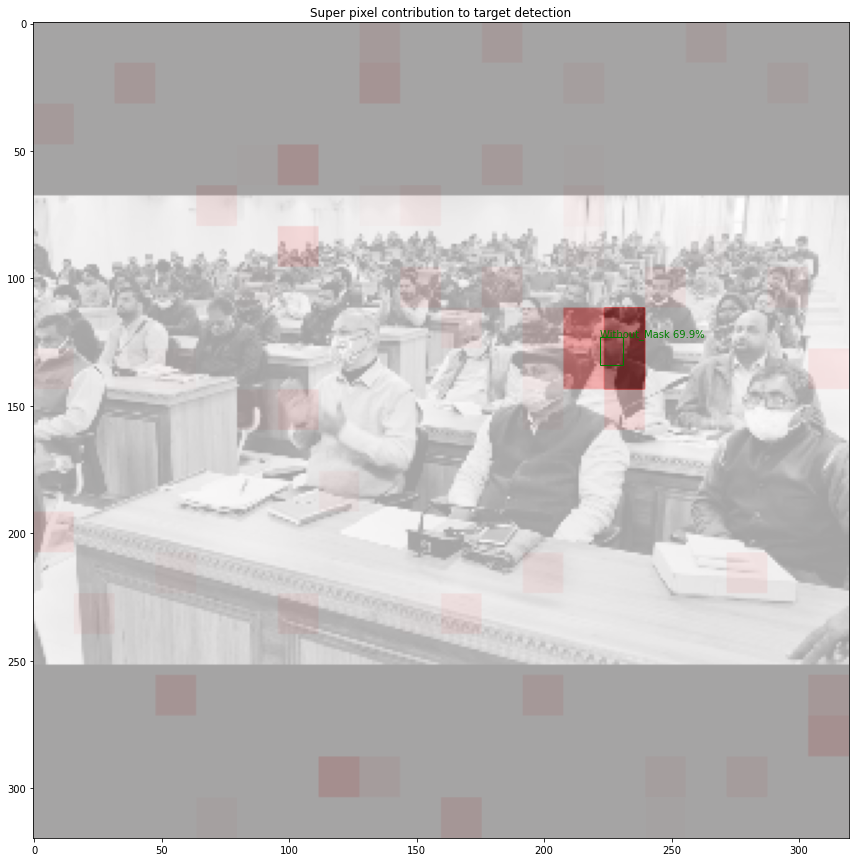

In [113]:
shap_result(img_pre,img_gray,target,16,320)

In [117]:
def over_all(path,img_size,confidence,iou,target_index,super_pixel_width,show_image_processing=0,show_yolo_result=0):
  img_org,img_pre,img_gray=image_processing(path,img_size,show_image_processing)
  output,prediction = model_processing(img_pre,confidence,iou,show_yolo_result)
  target = output[0].cpu().numpy()[target_index,:]
  scoring = OD2Score(target, conf_thresh=confidence, iou_thresh=iou)
  numpy2torch_converter = CastNumpy()
  shap_result(img_pre,img_gray,target,super_pixel_width,img_size,scoring)

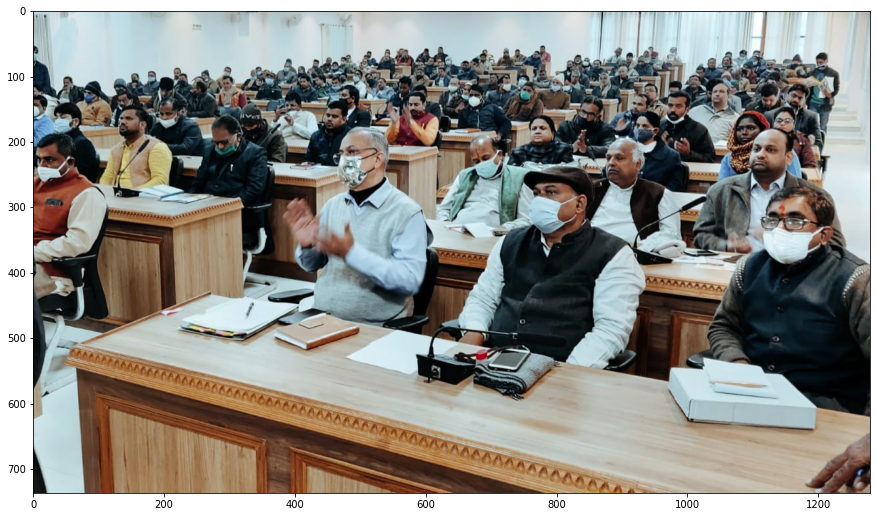

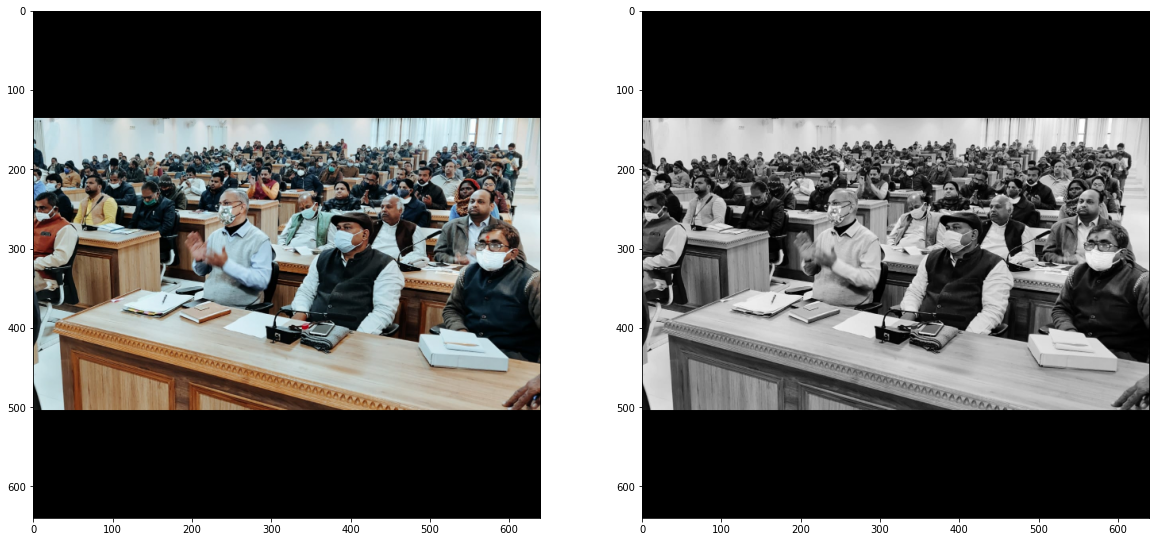

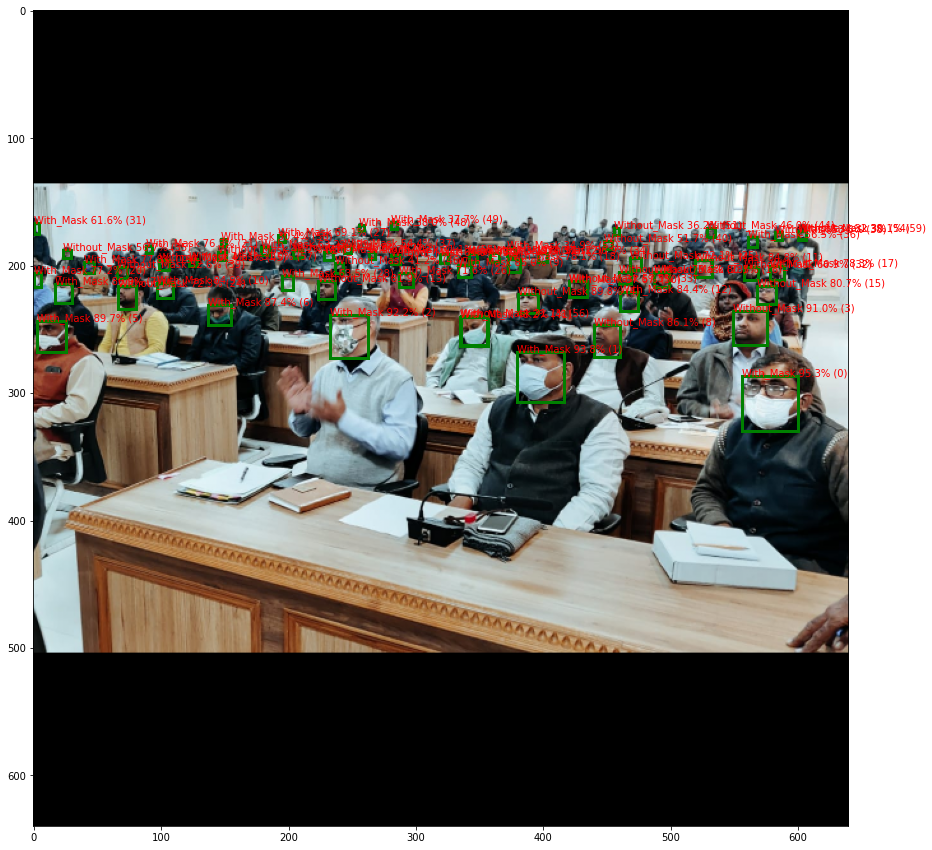


107 non-zero shap values found


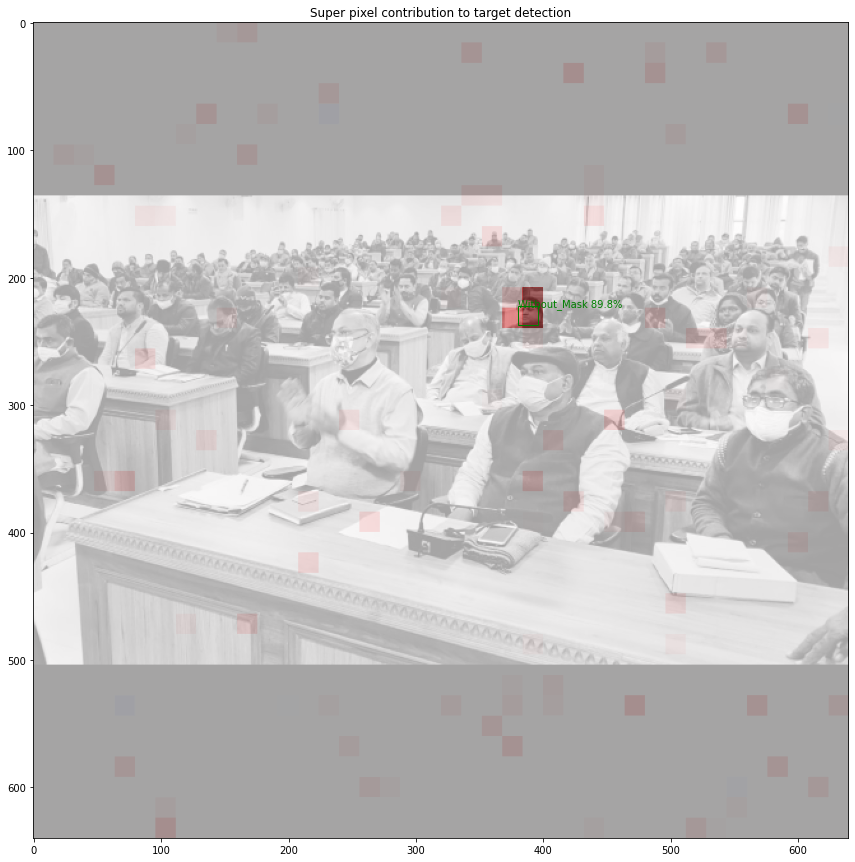

In [119]:
over_all('/content/image-mask-estimate/data/sample-images-india/2.jpg',640,0.3,0.3,4,16,1,1)